In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from latent_geometry.data import load_mnist_dataset
from latent_geometry.model.mnist_vae import EncoderVAE, DecoderVAE
from torch.utils.data import DataLoader
from torch import nn
import torch
import torch.functional as F

from tqdm import tqdm
import matplotlib.pyplot as plt
import itertools

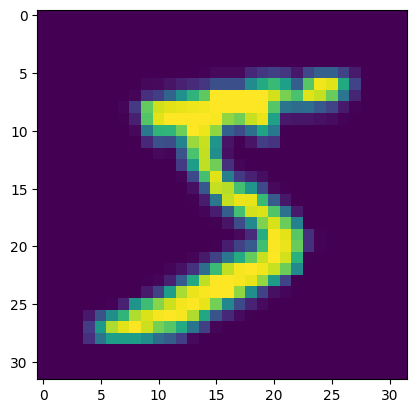

In [3]:
dataset = load_mnist_dataset("train")
img_single = dataset[0][0]
plt.imshow(img_single.squeeze(0))

In [4]:
train_dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
batch = next(iter(train_dataloader))[0]
batch.shape

torch.Size([64, 1, 32, 32])

In [43]:
import math


def print_nans(params):
    for param in params:
        print(f"# na = {param.isnan().sum()} out of {math.prod(param.shape)}")

In [44]:
params = list(encoder.parameters())
print_nans(params)

# na = 128 out of 128
# na = 8 out of 8
# na = 2048 out of 2048
# na = 16 out of 16
# na = 8192 out of 8192
# na = 32 out of 32
# na = 32768 out of 32768
# na = 64 out of 64
# na = 8192 out of 8192
# na = 128 out of 128
# na = 384 out of 384
# na = 3 out of 3


In [54]:
def train(
    encoder: nn.Module,
    decoder: nn.Module,
    dataloader: DataLoader,
    device: torch.device,
    epochs: int,
    lr: float,
):
    MAX_NORM = 1
    bce_loss_fun = nn.BCELoss(reduction="sum")
    encoder.to(device).train(), decoder.to(device).train()
    # models_params = itertools.chain(encoder.parameters(), decoder.parameters())
    models_params = encoder.parameters()
    optimizer = torch.optim.SGD(models_params, lr=lr)
    train_losses = []
    for epoch in tqdm(range(epochs)):
        running_loss = 0.0
        for batch in dataloader:
            imgs = batch[0].to(device)
            optimizer.zero_grad()

            # autoencoding
            mu, std = encoder(imgs)
            z = mu + torch.randn_like(mu) * std
            # z = mu + torch.randn_like(mu) * log_var.exp().pow(0.5)
            sampled_imgs = decoder(z)

            # losses
            bce_loss = bce_loss_fun(imgs, sampled_imgs)
            kl_div = -0.5 * torch.sum(1 + 2 * std.log() - mu.pow(2) - std.pow(2))
            # kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            loss = bce_loss + kl_div

            print(f"{bce_loss.item() = }, {kl_div.item() = }")
            running_loss += loss.item()

            print("encoder:")
            print_nans(encoder.parameters())
            print("decoder:")
            print_nans(decoder.parameters())

            # optimizer

            # loss.backward()
            bce_loss.backward()
            nn.utils.clip_grad_norm_(
                models_params, max_norm=MAX_NORM, error_if_nonfinite=True
            )
            optimizer.step()
        print(running_loss)
        train_losses.append(running_loss)
    return train_losses

In [55]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [56]:
encoder = EncoderVAE()
decoder = DecoderVAE()

In [57]:
losses = train(
    encoder,
    decoder,
    DataLoader(dataset, batch_size=1, shuffle=True),
    torch.device("cuda"),
    epochs=10,
    lr=0.00,
)
losses

  0%|          | 0/10 [00:00<?, ?it/s]

bce_loss.item() = 36029.46875, kl_div.item() = 0.17737290263175964
encoder:
# na = 0 out of 128
# na = 0 out of 8
# na = 0 out of 2048
# na = 0 out of 16
# na = 0 out of 8192
# na = 0 out of 32
# na = 0 out of 32768
# na = 0 out of 64
# na = 0 out of 8192
# na = 0 out of 128
# na = 0 out of 384
# na = 0 out of 3
decoder:
# na = 0 out of 128
# na = 0 out of 64
# na = 0 out of 65536
# na = 0 out of 64
# na = 0 out of 32768
# na = 0 out of 32
# na = 0 out of 8192
# na = 0 out of 16
# na = 0 out of 256
# na = 0 out of 1
bce_loss.item() = nan, kl_div.item() = nan
encoder:
# na = 128 out of 128
# na = 8 out of 8
# na = 2048 out of 2048
# na = 16 out of 16
# na = 8192 out of 8192
# na = 32 out of 32
# na = 32768 out of 32768
# na = 64 out of 64
# na = 8192 out of 8192
# na = 128 out of 128
# na = 384 out of 384
# na = 3 out of 3
decoder:
# na = 0 out of 128
# na = 0 out of 64
# na = 0 out of 65536
# na = 0 out of 64
# na = 0 out of 32768
# na = 0 out of 32
# na = 0 out of 8192
# na = 0 out of

  0%|          | 0/10 [00:04<?, ?it/s]

# na = 0 out of 128
# na = 0 out of 64
# na = 0 out of 65536
# na = 0 out of 64
# na = 0 out of 32768
# na = 0 out of 32
# na = 0 out of 8192
# na = 0 out of 16
# na = 0 out of 256
# na = 0 out of 1
bce_loss.item() = nan, kl_div.item() = nan
encoder:
# na = 128 out of 128
# na = 8 out of 8
# na = 2048 out of 2048
# na = 16 out of 16
# na = 8192 out of 8192
# na = 32 out of 32
# na = 32768 out of 32768
# na = 64 out of 64
# na = 8192 out of 8192
# na = 128 out of 128
# na = 384 out of 384
# na = 3 out of 3
decoder:
# na = 0 out of 128
# na = 0 out of 64
# na = 0 out of 65536
# na = 0 out of 64
# na = 0 out of 32768
# na = 0 out of 32
# na = 0 out of 8192
# na = 0 out of 16
# na = 0 out of 256
# na = 0 out of 1
bce_loss.item() = nan, kl_div.item() = nan
encoder:
# na = 128 out of 128
# na = 8 out of 8
# na = 2048 out of 2048
# na = 16 out of 16
# na = 8192 out of 8192
# na = 32 out of 32
# na = 32768 out of 32768
# na = 64 out of 64
# na = 8192 out of 8192
# na = 128 out of 128
# na = 38

KeyboardInterrupt: 